In [21]:
import rmtchem 
import timeit
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.integrate import solve_bvp
from scipy.signal import argrelmax,find_peaks
from scipy.stats import ttest_rel,ttest_1samp
import imp
import cantera as ct
imp.reload(rmtchem)
from scipy.sparse import csr_matrix
plt.rcParams.update({'font.size': 12, 'pdf.fonttype':42,'text.usetex': False, 'font.family': 'serif'})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

### Example graph 

58


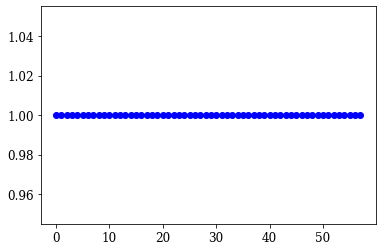

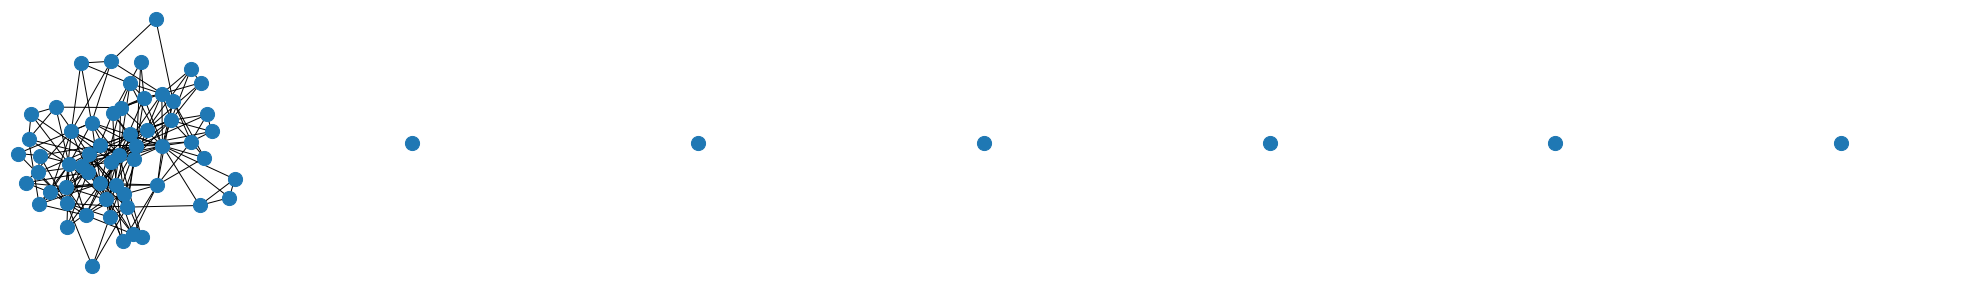

In [2]:
n=64
c=0.5
nr=int(c*n)
seed=1

np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr)
adj=np.zeros((n,n))
for r in range(2*nr):
    reac=np.where(eta[r]>0)[0]
    prod=np.where(nu[r]>0)[0]
    for i in reac:
        for j in prod:
            adj[i,j]=1
        #if species are both reactants, they affect rates of change of each other
        for j in reac:
            adj[i,j]=1
g=nx.convert_matrix.from_numpy_matrix(adj)

lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]

print(n)
X0=np.exp(-G)
XD1=np.zeros(n)
XD2=np.zeros(n)
success,Xs2=rmtchem.steady(X0,eta,nu,k,XD1,XD2)
plt.plot(Xs2/X0,'bo')
plt.show()

g=nx.convert_matrix.from_numpy_matrix(adj)
components=list(sorted(nx.connected_components(g)))
if len(components)>1:
    fig, ax = plt.subplots(1,len(components),figsize=(5*len(components),5))
    for i in range(len(components)):
        comp=list(components)[i]
        idx=np.array(list(comp))
        nx.draw(nx.convert_matrix.from_numpy_matrix(adj[np.ix_(idx,idx)]),node_size=200,ax=ax[i])
        ax[i].axis('off')
else:
    nx.draw(g,node_size=200)

plt.savefig('plots/fig1b.pdf')
plt.show()
# Xs,success=rmtchem.integrate(X0,eta,nu,k,XD1,XD2,100,0.1,prog=True)
# plt.plot(Xs)
# plt.show()

### Chemical network percolation

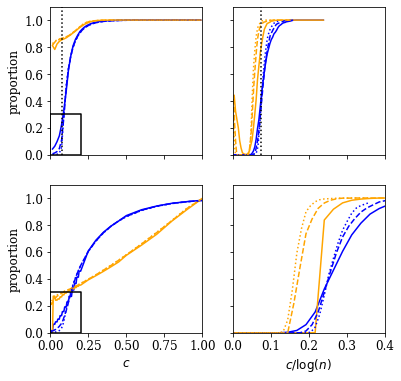

In [3]:
ns=[64,512,4096]
ls=['-','--',':']

plt.subplots(2,2,figsize=(6,6))

plt.subplot(2,2,1)
plt.ylabel("proportion")
plt.ylim(0,1.1)
plt.xlim(0,1)
locs, labels = plt.xticks()
plt.xticks(locs,[])

for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/er/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/(20/3),dat[:,2],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1]/(20/3),dat[:,3],color='orange',linestyle=ls[i])
plt.plot([0,0.2,0.2,0,0],[0.3,0.3,0,0,0.3],color='black')
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')

plt.subplot(2,2,2)
plt.ylim(0,1.1)
plt.xlim(0,0.4)
locs, labels = plt.yticks()
plt.yticks(locs,[])
plt.ylim(0,1.1)

locs, labels = plt.xticks()
plt.xticks(locs,[])
for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/er/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/(20/3)/np.log(n),dat[:,4],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1]/(20/3)/np.log(n),dat[:,5],color='orange',linestyle=ls[i])
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')

plt.subplot(2,2,3)
plt.xlabel('$c$')
plt.ylabel("proportion")
plt.ylim(0,1.1)
plt.xlim(0,1)
for i in range(len(ns)):
    n=ns[i]
    dat=np.loadtxt('data/sing/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1],dat[:,2],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1],dat[:,3],color='orange',linestyle=ls[i])
    
plt.plot([0,0.2,0.2,0,0],[0.3,0.3,0,0,0.3],color='black')

plt.subplot(2,2,4)
plt.xlabel('$c/\log(n)$')
plt.xlim(0,0.4)
plt.ylim(0,1.1)
locs, labels = plt.yticks()
plt.yticks(locs,[])
plt.ylim(0,1.1)

for i in range(len(ns)):
    n=ns[i]
    dat=np.loadtxt('data/sing/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/np.log(n),dat[:,4],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1]/np.log(n),dat[:,5],color='orange',linestyle=ls[i])
plt.savefig('plots/fig2.pdf')
plt.show()

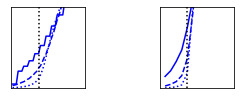

In [4]:
ns=[64,512,4096]
ls=['-','--',':']
fig, axs = plt.subplots(1,2,figsize=(4,1.5))

plt.subplot(1,2,1)
plt.xlim(0,0.2)
plt.ylim(0,0.3)
plt.yticks([],[])
plt.xticks([],[])

for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/sing/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1],dat[:,2],color='blue',linestyle=ls[i])
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')

plt.subplot(1,2,2)
plt.xlim(0,0.2)
plt.ylim(0,0.3)
plt.yticks([],[])
plt.xticks([],[])

for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/er/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/(20/3),dat[:,2],color='blue',linestyle=ls[i])
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')
plt.subplots_adjust(wspace=1.0,hspace=0.0)

plt.savefig('plots/fig2insets.pdf')
plt.show()


### Bifurcation examples

64 133 6 0 74
0.834052	1.562500e-04	8381	
Saddle-node bifurcation!	83.405234	1.562500e-04	1	1	2.007646	0.000000
0.390291	-7.812500e-05	12909	
Saddle-node bifurcation!	39.029063	-7.812500e-05	1	1	2.005689	0.000000


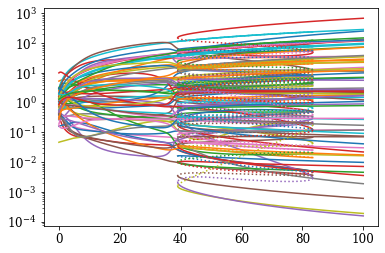

In [5]:
imp.reload(rmtchem)
n=64
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=0
seed=74
print(n,nr,nd,na,seed)

np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
start=timeit.default_timer()

Xs,epsilons,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2, d1min,d1max,d1min,1e-2,output=2,stop=False)

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

83.50523437500576 687.9665836248031 0.08439082838004776
0.000004	0.000000	1008	2	lsoda	
Found steady state!
True 0.8895186770000123


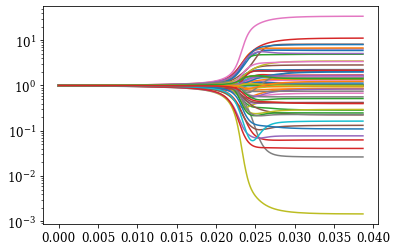

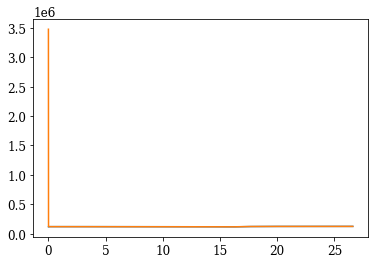

119830.84541333675 124246.3934916299 119830.84541330111 124249.67232089362


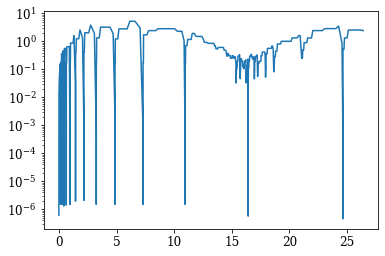

0


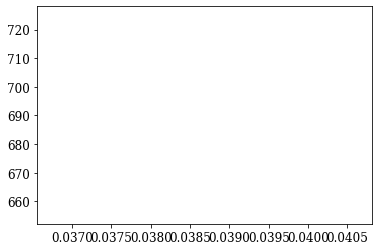

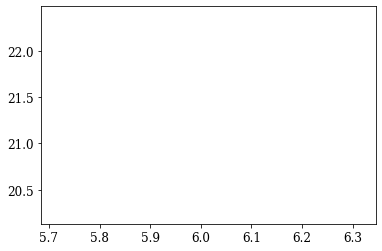

In [6]:
imp.reload(rmtchem)
m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
X0=Xs[m0]
epsilon=epsilons[m0]+1e-1
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilon,tscale,dt)
start=timeit.default_timer()
ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True)
# ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,tscale,dt,output=True)
stop=timeit.default_timer()
print(success,stop-start)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/X0)
plt.show()
sd=[rmtchem.Sdot(rmtchem.rates(Xts[:,i],eta,nu,k)) for i in range(len(ts))]
wd=[rmtchem.Wdot(Xts[:,i],G,(1+epsilon)*XD1,XD2) for i in range(len(ts))]
sd1=rmtchem.Sdot(rmtchem.rates(X0,eta,nu,k))
wd1=rmtchem.Wdot(X0, G, (1+epsilon-1e-1)*XD1, XD2)
sd2=np.sum(np.diff(ts)[m0-1:]*sd[m0:])/np.sum(np.diff(ts)[m0-1:])
wd2=np.sum(np.diff(ts)[m0-1:]*wd[m0:])/ np.sum(np.diff(ts)[m0-1:])
plt.plot(ts,sd)
plt.plot(ts,wd)
plt.show()
print(sd1, sd2, wd1, wd2)

plt.yscale('log')
plt.plot(ts[:-1],np.diff(ts)/dt)
plt.show()
print(state)
plt.plot(ts[m0:]/tscale,np.linalg.norm(Xts,axis=0)[m0:])
plt.show()
plt.plot(Xts[0,m0:],Xts[1,m0:],linewidth=0.1)
plt.show()


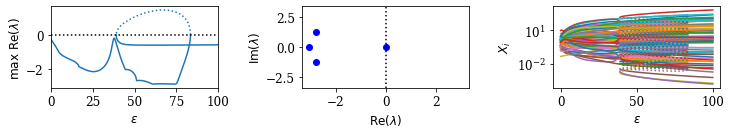

In [7]:
plt.subplots(1,3,figsize=(12,1.5))
plt.subplot(1,3,1)
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\mathrm{max}~\mathrm{Re}(\lambda)$')
# plt.yscale('symlog')
plt.xlim(0,100)
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
        plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],color=colors[0])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
        plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls=':',color=colors[0])
plt.plot([0,100],[0,0],ls=':',color='black')

        
plt.subplot(1,3,2)
m=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
lim=1.1*np.max(np.abs(evals[m,np.argsort(np.real(evals[m]))[-3:]]))
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
plt.ylabel(r'$\mathrm{Im}(\lambda)$')
plt.xlabel(r'$\mathrm{Re}(\lambda)$')
plt.plot(np.real(evals[m]),np.imag(evals[m]),'bo')
plt.plot([0,0],[-lim,lim],ls=':',color='black')

plt.subplot(1,3,3)
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
plt.ylabel(r"$X_i$")
plt.xlabel('$\epsilon$')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])
        
plt.subplots_adjust(wspace=0.5,hspace=0.0)
plt.savefig('plots/fig3a.pdf')
plt.show()

64 133 6 0 21
0.426500	1.000000e-02	4266	
Hopf bifurcation!		42.660000
10000 10	1.000000e-02	10000	


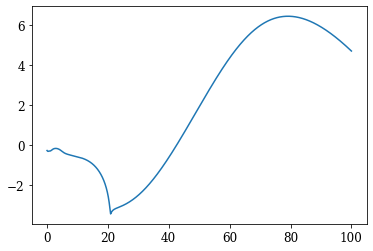

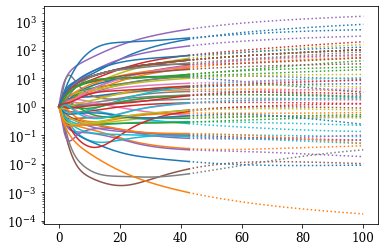

In [8]:
imp.reload(rmtchem)
n=64
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=0
seed=21
print(n,nr,nd,na,seed)

np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na)

row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]

d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
Xs,epsilons,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2,d1min,d1max, d1min,1e-2, output=2,stop=False)
print(len(Xs),bif)
plt.plot(epsilons,np.max(np.real(evals),axis=1))
plt.show()

inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i]/np.exp(-G[i]),color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i]/np.exp(-G[i]),ls=':',color=colors[np.mod(i,len(colors))])
        
plt.show()

42.750000000000085 153326.91293661378 0.043552320559561236
0.000000	0.000000	15700	162	lsoda	
Found oscillating state!
True 12.094936153999981


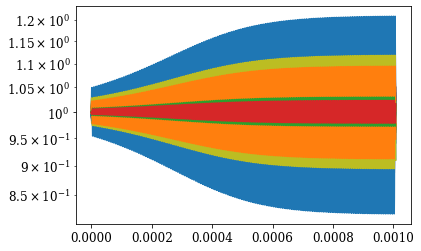

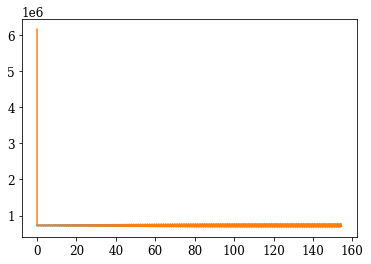

720951.6328205254 724879.0600906872 720951.6328205673 724880.4838305407


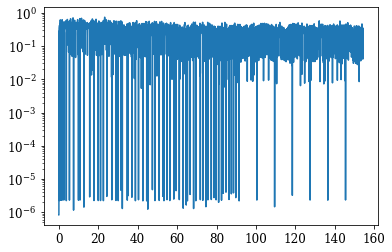

1


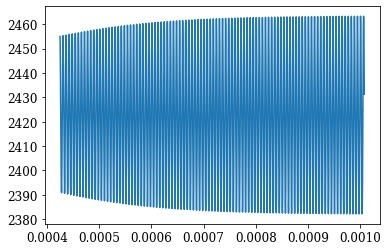

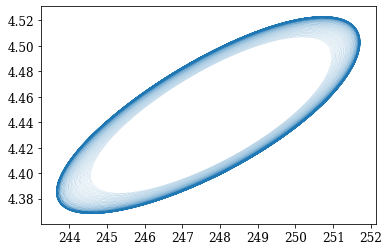

In [9]:
imp.reload(rmtchem)
m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
X0=Xs[m0]
epsilon=epsilons[m0]+1e-1
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilon,tscale,dt)
start=timeit.default_timer()
ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True)
stop=timeit.default_timer()
print(success,stop-start)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/X0)
plt.show()
sd=[rmtchem.Sdot(rmtchem.rates(Xts[:,i],eta,nu,k)) for i in range(len(ts))]
wd=[rmtchem.Wdot(Xts[:,i],G,(1+epsilon)*XD1,XD2) for i in range(len(ts))]
sd1=rmtchem.Sdot(rmtchem.rates(X0,eta,nu,k))
wd1=rmtchem.Wdot(X0, G, (1+epsilon-1e-1)*XD1, XD2)
sd2=np.sum(np.diff(ts)[m0-1:]*sd[m0:])/np.sum(np.diff(ts)[m0-1:])
wd2=np.sum(np.diff(ts)[m0-1:]*wd[m0:])/ np.sum(np.diff(ts)[m0-1:])
plt.plot(ts,sd)
plt.plot(ts,wd)
plt.show()
print(sd1, sd2, wd1, wd2)

plt.yscale('log')
plt.plot(ts[:-1],np.diff(ts)/dt)
plt.show()
print(state)
plt.plot(ts[m0:]/tscale,np.linalg.norm(Xts,axis=0)[m0:])
plt.show()
plt.plot(Xts[0,m0:],Xts[1,m0:],linewidth=0.1)
plt.show()

43.650000000000084 153326.91293661378 0.004355232055956519
0.000000	0.000000	4718	19	lsoda	
Found oscillating state!
True 3.553582931000051


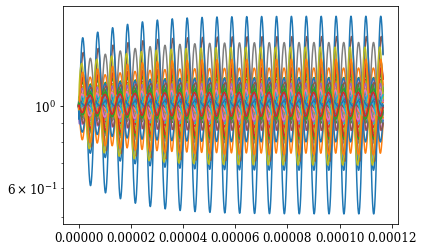

In [10]:
m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
epsilon=epsilons[m0]+1e0
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilon,tscale,dt)
start=timeit.default_timer()
ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True,maxcycles=20)
stop=timeit.default_timer()
print(success,stop-start)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/X0)
plt.show()

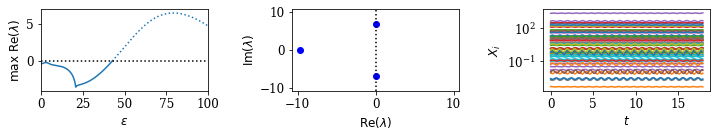

In [11]:
plt.subplots(1,3,figsize=(12,1.5))
plt.subplot(1,3,1)
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\mathrm{max}~\mathrm{Re}(\lambda)$')
plt.xlim(0,100)
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
        plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],color=colors[0])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
        plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls=':',color=colors[0])
plt.plot([0,100],[0,0],ls=':',color='black')

plt.subplot(1,3,2)
m=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
lim=1.1*np.max(np.abs(evals[m,np.argsort(np.real(evals[m]))[-3:]]))
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
plt.ylabel(r'$\mathrm{Im}(\lambda)$')
plt.xlabel(r'$\mathrm{Re}(\lambda)$')
plt.plot(np.real(evals[m]),np.imag(evals[m]),'bo')
plt.plot([0,0],[-lim,lim],ls=':',color='black')


plt.subplot(1,3,3)
plt.yscale('log')
plt.ylabel('$X_i$')
plt.xlabel('$t$')
plt.plot(ts,np.transpose(Xts))
plt.subplots_adjust(wspace=0.5,hspace=0.0)
plt.savefig('plots/fig3b.pdf')
plt.show()

### Chemical chaos 

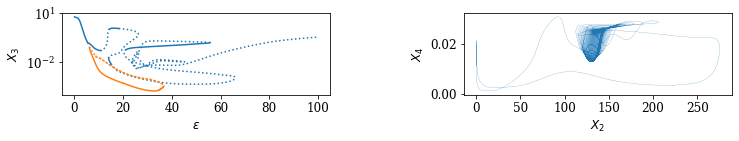

In [63]:
Xs=np.load('data/chaos/Xs1.npy')
epsilons=np.load('data/chaos/epsilons1.npy')
evals=np.load('data/chaos/evals1.npy')
Xs2=np.load('data/chaos/Xs2.npy')
epsilons2=np.load('data/chaos/epsilons2.npy')
evals2=np.load('data/chaos/evals2.npy')
Xs3=np.load('data/chaos/Xs3.npy')
epsilons3=np.load('data/chaos/epsilons3.npy')
evals3=np.load('data/chaos/evals3.npy')
ts=np.load('data/chaos/ts.npy')
Xts=np.load('data/chaos/Xts.npy')
m=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
tmax=2*np.pi/(np.imag(evals[m,np.argmax(np.real(evals[m]))]))*500

lst=range(n)
lst=[3]

plt.subplots(1,2,figsize=(12,1.5))

plt.subplot(1,2,1)

plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$X_3$')
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[0])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[0])

inds1=np.where(np.max(np.real(evals2),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals2),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons2[inds],Xs2[inds,i],color=colors[1])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons2[inds],Xs2[inds,i],ls=':',color=colors[1])

inds1=np.where(np.max(np.real(evals3),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals3),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons3[inds],Xs3[inds,i],color=colors[1])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons3[inds],Xs3[inds,i],ls=':',color=colors[1])

ax=plt.subplot(1,2,2)
ax.set_rasterization_zorder(0)
plt.xlabel(r'$X_2$')
plt.ylabel(r'$X_4$')
tinds=np.where(ts>tmax/10)[0]
ind1=2
ind2=4
plt.plot(Xts[ind1,tinds],Xts[ind2,tinds],zorder=-1,linewidth=0.01,alpha=1.0)

plt.subplots_adjust(wspace=0.5,hspace=0.0)
plt.savefig('plots/fig3c.pdf',dpi=300)
plt.show()

### Bifurcations vs reactivity, catalyticity, and driving proportion

(27, 6)


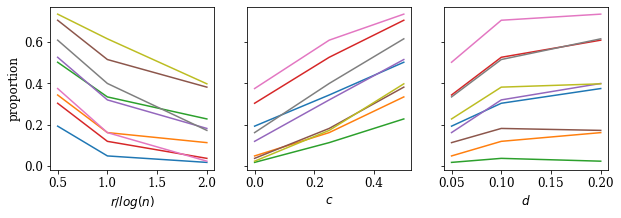

In [13]:
ns=[64]
cs=[0.5,1.0,2.0]
ds=[0.05, 0.1, 0.2]
ass=[0,0.25,0.5]
tab=[]
for n in ns:
    for c in cs:
        for d in ds:
            for a in ass:
                vals=np.loadtxt('data/hystereses/'+str(n)+'_'+str(c)+'_'+str(d)+'_'+str(a)+'.txt')
                tot=np.count_nonzero(vals[:,4]==0)+np.count_nonzero(vals[:,4]==1)+np.count_nonzero(vals[:,4]==2)
                tab.append([c, d, a, np.count_nonzero(vals[:,4]==1)/tot,  np.count_nonzero(vals[:,4]==2)/tot,np.count_nonzero(vals[:,4]<0)/tot])
                
tab=np.array(tab)
print(tab.shape)
cs=np.unique(tab[:,0])
ds=np.unique(tab[:,1])
ass=np.unique(tab[:,2])

fig,ax=plt.subplots(1,3,figsize=(10,3))
plt.subplot(1,3,1)
plt.xlabel('$r/log(n)$')
plt.ylabel('proportion')
for d in ds:
    for a in ass:
        ind=np.where(np.all(tab[:,[1,2]]==[d,a],axis=1))[0]
        plt.plot(tab[ind,0],tab[ind,4]+tab[ind,3])

plt.subplot(1,3,2)
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
plt.xlabel('$c$')
for d in ds:
    for c in cs:
        ind=np.where(np.all(tab[:,[1,0]]==[d,c],axis=1))[0]
        plt.plot(tab[ind,2],tab[ind,4]+tab[ind,3])

plt.subplot(1,3,3)
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
plt.xlabel('$d$')
for a in ass:
    for c in cs:
        ind=np.where(np.all(tab[:,[2,0]]==[a,c],axis=1))[0]
        plt.plot(tab[ind,1],tab[ind,4]+tab[ind,3])
plt.savefig('plots/fig4a.pdf',transparent=True)
plt.show()

[ 10  12  13 159 183 203 231 233 334 348 352 376  37 380 456 484 495 512
 521 526 556 557 638 669 695 731 766 786 792 821 840 920 942 946 957 972
 978]
[1015  117   21  232  296  298    2  304  313  322  340  351   35  395
  460  468  477  501  508  518  528  530  531  537  577   57  627  631
  673  686  753  807  815   83   84  863  906  962]
[115 149  16 196 213 219 275 363 369 381 448 458 465 489  48 505 511 535
 564 614 684 702 706 799 816 836  89  93 950 963]


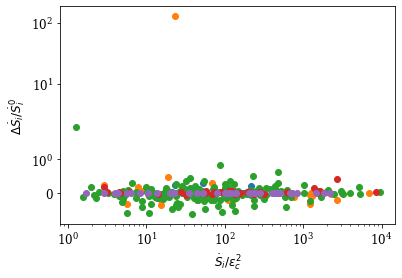

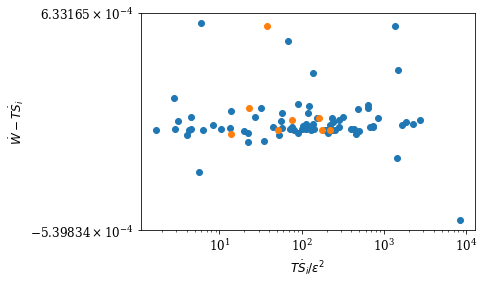

In [65]:
vals=np.loadtxt('data/hystereses/64_0.5_0.1_0.txt')


inds=np.where(np.all(vals[:,[4,10]]==[1,1],axis=1))[0]
inds2=np.where(np.abs((vals[inds,7]-vals[inds,6])/vals[inds,6])>0.01)[0]
inds3=np.where(np.abs((vals[inds,7]-vals[inds,6])/vals[inds,6])<0.01)[0]
inds5=np.where(np.all(vals[:,[4,10]]==[1,0],axis=1))[0]
inds4=np.where(np.all(vals[:,[4,10]]==[2,1],axis=1))[0]
inds6=np.where(np.all(vals[:,[4,10]]==[2,0],axis=1))[0]

plt.xscale('log')
plt.yscale('symlog')
plt.ylabel(r'$\Delta \dot{S}_i / \dot{S}^0_i$')
plt.xlabel(r'$\dot{S}_i / \epsilon_c^2$')
plt.scatter(vals[inds4,6]/vals[inds4,5]**2,(vals[inds4,7]-vals[inds4,6])/vals[inds4,6])
plt.scatter(vals[inds5,6]/vals[inds5,5]**2,(vals[inds5,7]-vals[inds5,6])/vals[inds5,6])
plt.scatter(vals[inds6,6]/vals[inds6,5]**2,(vals[inds6,7]-vals[inds6,6])/vals[inds6,6])
plt.scatter(vals[inds[inds2],6]/vals[inds[inds2],5]**2,(vals[inds[inds2],7]-vals[inds[inds2],6])/vals[inds[inds2],6])
plt.scatter(vals[inds[inds3],6]/vals[inds[inds3],5]**2,(vals[inds[inds3],7]-vals[inds[inds3],6])/vals[inds[inds3],6])

print(vals[inds[inds2],1].astype(int))
print(vals[inds[inds3],1].astype(int))
print(vals[inds5,1].astype(int))
plt.show()

plt.xscale('log')
plt.yscale('symlog')
plt.ylabel(r'$\dot{W}-T\dot{S}_i$')
plt.xlabel(r'$T\dot{S}_i / \epsilon^2$')
vals=np.loadtxt('data/hystereses/64_0.5_0.1_0.txt')
inds=np.where(np.all(vals[:,[4,10]]==[1,1],axis=1))[0]
plt.scatter(vals[inds,6]/vals[inds,5]**2,(vals[inds,7]-vals[inds,9])/vals[inds,6])
inds=np.where(np.all(vals[:,[4,10]]==[2,1],axis=1))[0]
plt.scatter(vals[inds,6]/vals[inds,5]**2,(vals[inds,7]-vals[inds,9])/vals[inds,6])
plt.show()

In [19]:
vals=np.loadtxt('data/hystereses/64_0.5_0.1_0.txt')

print(np.count_nonzero(np.all(vals[:,[4,10]]==[1,1] ,axis=1)),'Hopf leading to oscillatory')
print(np.count_nonzero(np.all(vals[:,[4,10]]==[1,0] ,axis=1)),'subcritical Hopf leading to steady')
print(np.count_nonzero(np.all(vals[:,[4,10]]==[2,0] ,axis=1)),'saddle-node leading to steady')
print(np.count_nonzero(np.all(vals[:,[4,10]]==[2,1] ,axis=1)),'saddle-node leading to oscillatory')

75 Hopf leading to oscillatory
30 subcritical Hopf leading to steady
177 saddle-node leading to steady
8 saddle-node leading to oscillatory


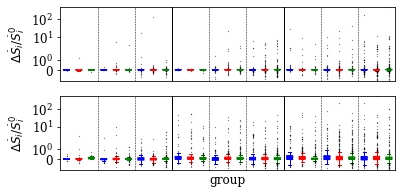

In [20]:
ns=[64]
cs=[2.0,1.0,0.5]
ds=[0.05,0.1,0.2]
ass=[0,0.25,0.5]
c1='blue'
c2='red'
c3='green'

fig,ax=plt.subplots(2,1,figsize=(6,3))
plt.tick_params(axis='x', which='both', bottom=True,  top=False, labelbottom=False) 
plots1=[]
plots2=[]
for n in ns:
    for a in ass:
        for c in cs:
            for d in ds:
                vals=np.loadtxt('data/hystereses/'+str(n)+'_'+str(c)+'_'+str(d)+'_'+str(a)+'.txt')
                inds1=np.intersect1d(np.intersect1d(np.where(vals[:,4]==1)[0],np.where(vals[:,10]!=-1)[0]),np.where(np.isfinite(vals[:,7])))
                inds2=np.intersect1d(np.intersect1d(np.where(vals[:,4]==2)[0],np.where(vals[:,10]!=-1)[0]),np.where(np.isfinite(vals[:,7])))
                plots1.append((vals[inds1,7]-vals[inds1,6])/vals[inds1,6])
                plots2.append((vals[inds2,7]-vals[inds2,6])/vals[inds2,6])

            
plt.subplot(2,1,1)
plt.xticks([])
plt.ylabel(r'$\Delta \dot{S}_i / \dot{S}^0_i$')
plt.yscale('symlog')
box1=plt.boxplot(plots1,notch=True,patch_artist=True,showfliers=True,flierprops={'markersize':0.2})
for item in ['boxes', 'fliers', 'medians']:
    plt.setp(box1[item][::3], color=c1)
    plt.setp(box1[item][1::3], color=c2)
    plt.setp(box1[item][2::3], color=c3)
for item in ['whiskers','caps']:
    plt.setp(box1[item][::6], color=c1)
    plt.setp(box1[item][1::6], color=c1)
    plt.setp(box1[item][2::6], color=c2)
    plt.setp(box1[item][3::6], color=c2)
    plt.setp(box1[item][4::6], color=c3)
    plt.setp(box1[item][5::6], color=c3)

ymin=1.1*np.min([np.min(plots1[i]) for i in range(len(plots1))])
ymax=1.1*np.max([np.max(plots1[i]) for i in range(len(plots1))])
plt.ylim(ymin,ymax)
plt.plot([3.5,3.5],[ymin,ymax],ls='--',color='black',linewidth=0.5)
plt.plot([6.5,6.5],[ymin,ymax],ls='--',color='black',linewidth=0.5)
plt.plot([9.5,9.5],[ymin,ymax],ls='-',color='black',linewidth=1.0)
plt.plot([12.5,12.5],[ymin,ymax],ls='--',color='black',linewidth=0.5)
plt.plot([15.5,15.5],[ymin,ymax],ls='--',color='black',linewidth=0.5)
plt.plot([18.5,18.5],[ymin,ymax],ls='-',color='black',linewidth=1.0)
plt.plot([21.5,21.5],[ymin,ymax],ls='--',color='black',linewidth=0.5)
plt.plot([24.5,24.5],[ymin,ymax],ls='--',color='black',linewidth=0.5)
plt.xticks([])


plt.subplot(2,1,2)
plt.xlabel('group')
plt.ylabel(r'$\Delta \dot{S}_i / \dot{S}^0_i$')
plt.yscale('symlog')
box1=plt.boxplot(plots2,notch=True,patch_artist=True,showfliers=True,flierprops={'markersize':0.2})
for item in ['boxes', 'fliers', 'medians']:
    plt.setp(box1[item][::3], color=c1)
    plt.setp(box1[item][1::3], color=c2)
    plt.setp(box1[item][2::3], color=c3)
for item in ['whiskers','caps']:
    plt.setp(box1[item][::6], color=c1)
    plt.setp(box1[item][1::6], color=c1)
    plt.setp(box1[item][2::6], color=c2)
    plt.setp(box1[item][3::6], color=c2)
    plt.setp(box1[item][4::6], color=c3)
    plt.setp(box1[item][5::6], color=c3)

ymin=1.1*np.min([np.min(plots2[i]) for i in range(len(plots2))])
ymax=1.1*np.max([np.max(plots2[i]) for i in range(len(plots2))])
plt.ylim(ymin,ymax)
plt.plot([3.5,3.5],[ymin,ymax],ls='--',color='black',linewidth=0.5)
plt.plot([6.5,6.5],[ymin,ymax],ls='--',color='black',linewidth=0.5)
plt.plot([9.5,9.5],[ymin,ymax],ls='-',color='black',linewidth=1.0)
plt.plot([12.5,12.5],[ymin,ymax],ls='--',color='black',linewidth=0.5)
plt.plot([15.5,15.5],[ymin,ymax],ls='--',color='black',linewidth=0.5)
plt.plot([18.5,18.5],[ymin,ymax],ls='-',color='black',linewidth=1.0)
plt.plot([21.5,21.5],[ymin,ymax],ls='--',color='black',linewidth=0.5)
plt.plot([24.5,24.5],[ymin,ymax],ls='--',color='black',linewidth=0.5)
plt.xticks([])

plt.savefig('plots/fig4b.pdf')
plt.show()


In [25]:
ns=[64]
for n in ns:
    for a in ass:
        for c in cs:
            for d in ds:
                vals=np.loadtxt('data/hystereses/'+str(n)+'_'+str(c)+'_'+str(d)+'_'+str(a)+'.txt')
                inds1=np.intersect1d(np.intersect1d(np.where(vals[:,4]==1)[0],np.where(vals[:,10]!=-1)[0]),np.where(np.isfinite(vals[:,7])))
                inds2=np.intersect1d(np.intersect1d(np.where(vals[:,4]==2)[0],np.where(vals[:,10]!=-1)[0]),np.where(np.isfinite(vals[:,7])))
                print(a,c,d,ttest_1samp((vals[inds1,7]-vals[inds1,6])/vals[inds1,6],0).pvalue,ttest_1samp((vals[inds2,7]-vals[inds2,6])/vals[inds2,6],0).pvalue)


0 2.0 0.05 0.5524457290150594 0.5113844511424859
0 2.0 0.1 0.43517745411873116 0.2944390235947616
0 2.0 0.2 0.6637770090684953 0.010282709555155081
0 1.0 0.05 0.2317166269763163 0.7424839381470889
0 1.0 0.1 0.23248694314611187 0.19706242543026498
0 1.0 0.2 0.3387947573660848 0.39141504152694107
0 0.5 0.05 0.31018685263601414 0.2630750510592811
0 0.5 0.1 0.3185078809001155 0.4822001432297319
0 0.5 0.2 0.2639954637047017 0.010224348939633456
0.25 2.0 0.05 0.29836913717429003 0.06092203888227409
0.25 2.0 0.1 0.0016396855764479281 0.029414881960462054
0.25 2.0 0.2 0.9793028945976636 0.013006335839302505
0.25 1.0 0.05 0.6522946721671653 0.05954197141466092
0.25 1.0 0.1 0.18323743224894057 0.01610678750177936
0.25 1.0 0.2 0.05298653793249727 0.0017234129988229542
0.25 0.5 0.05 0.16901530183413982 0.006477580750426638
0.25 0.5 0.1 0.0047036361391917135 0.006986616489813277
0.25 0.5 0.2 0.006513179918938741 0.04389809815269643
0.5 2.0 0.05 0.1868284261680786 0.00026586011178300953
0.5 2.0 0.1 

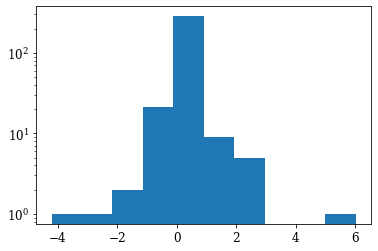

In [32]:
plt.yscale('log')
plt.hist(np.log(1+(vals[inds1,7]-vals[inds1,6])/vals[inds1,6]))
plt.show()